In [24]:
from wrangle_data_funcs import *
from modelling_funcs import *
from predict_gw_scores import *
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
def get_ewma_df(year, gw, ewma_alpha):
    gw_df = import_data_from_vastaav(year, gw)
    gw_df = add_team_data(gw_df)

    gw_df['full_name'] = gw_df['name'].apply(clean_name)

    player_value_cols = ['xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'minutes',
       'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'saves', 'starts',
       'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'yellow_cards']
    merge_cols_players = ['full_name', 'gw', 'total_points', 'position','team','opponent_team']
    ewma_gw_df_players = ewma(gw_df, 'full_name', player_value_cols, ewma_alpha, {'total_points': 'ewma_total_points'}, merge_cols_players)

    gw_df_teams = get_teams_df(gw_df)
    team_value_cols = ['team_goals', 'team_points']
    merge_cols_teams = ['team', 'gw']
    ewma_gw_df_teams = ewma(gw_df_teams, 'team', team_value_cols, ewma_alpha, {'team_goals': 'ewma_team_goals',
                                                                            'team_points': 'ewma_team_points'}, merge_cols_teams)
    merged_ewma_df = merge_ewma_dfs(ewma_gw_df_players, ewma_gw_df_teams, year)
    return merged_ewma_df

In [26]:
def ewma(gw_df, groupby_col, value_cols, alpha, rename_dict, remerge_cols):
    # Ensure the DataFrame is sorted by 'full_name' and 'gw'
    gw_df_sorted = gw_df.sort_values([groupby_col, 'gw']).reset_index()

    # Apply EWMA within each group
    ewma_gw_df = (
        gw_df_sorted
        .groupby(groupby_col, group_keys=False)
        [value_cols]
        .apply(lambda x: x.ewm(alpha=alpha, adjust=False).mean())
    )
    ewma_gw_df.rename(columns=rename_dict, inplace=True)
    ewma_gw_df = gw_df_sorted[remerge_cols].join(ewma_gw_df)
    return ewma_gw_df

In [27]:
def roll(gw_df, groupby_col, value_cols, alpha, rename_dict, remerge_cols, rolling_gws):
    # Ensure the DataFrame is sorted by 'full_name' and 'gw'
    gw_df_sorted = gw_df.sort_values([groupby_col, 'gw']).reset_index()

    # Apply rolling mean within each group
    rolling_gw_df = (
        gw_df_sorted
        .groupby(groupby_col, group_keys=False)
        [value_cols]
        .apply(lambda x: x.rolling(window=rolling_gws, min_periods=1).mean())
    )
    rolling_gw_df.rename(columns=rename_dict, inplace=True)
    rolling_gw_df = gw_df_sorted[remerge_cols].join(rolling_gw_df)
    return rolling_gw_df

In [28]:
def get_rolling_df(year, gw, ewma_alpha, rolling_gws):
    gw_df = import_data_from_vastaav(year, gw)
    gw_df = add_team_data(gw_df)

    gw_df['full_name'] = gw_df['name'].apply(clean_name)

    player_value_cols = ['xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'minutes',
       'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'saves', 'starts',
       'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'yellow_cards']
    merge_cols_players = ['full_name', 'gw', 'total_points', 'position','team','opponent_team']
    ewma_gw_df_players = roll(gw_df, 'full_name', player_value_cols, ewma_alpha, {'total_points': 'ewma_total_points'}, merge_cols_players, rolling_gws)

    gw_df_teams = get_teams_df(gw_df)
    team_value_cols = ['team_goals', 'team_points']
    merge_cols_teams = ['team', 'gw']
    ewma_gw_df_teams = roll(gw_df_teams, 'team', team_value_cols, ewma_alpha, {'team_goals': 'ewma_team_goals',
                                                                            'team_points': 'ewma_team_points'}, merge_cols_teams, rolling_gws)
    merged_ewma_df = merge_ewma_dfs(ewma_gw_df_players, ewma_gw_df_teams, year)
    return merged_ewma_df

In [29]:
training_year, training_n_gws, pred_year, pred_gw, alpha, features, model, roll_gws, output = get_params()

In [30]:
year = training_year
n_gws = training_n_gws
alpha = alpha

In [31]:
ewma_df = get_ewma_df(year, n_gws, alpha)

In [32]:
roll_df = get_rolling_df(year, n_gws, alpha, rolling_gws=5)

In [33]:
##########

In [34]:
# get_training_df
year = training_year
n_gws = training_n_gws
alpha = alpha

# gw_df = ewma_df.copy()
gw_df = roll_df.copy()

training_df = lag_data_for_training(gw_df).dropna(subset=['total_points_nw'])
non_zero_players = training_df.groupby('full_name').sum().query('total_points_nw>0').index
training_df_f = training_df.query('gw>1 and full_name in @non_zero_players')


In [35]:
test_model(training_df_f, features, LinearRegression)

{'GK': 2.125, 'DEF': 2.157, 'MID': 2.271, 'FWD': 2.785}


{'GK': 2.125, 'DEF': 2.157, 'MID': 2.271, 'FWD': 2.785}

In [39]:
def test_model_params(avg_type, training_gw_limit, model_func, training_year, roll_gws=np.nan):
    _, training_n_gws, pred_year, pred_gw, alpha, features, _, roll_gws, output = get_params()

    year = training_year
    n_gws = training_n_gws
    alpha = alpha
    roll_gws = 5
    if avg_type == 'ewma':
        gw_df = get_ewma_df(year, n_gws, alpha)
    elif avg_type == 'rolling':
        gw_df = get_rolling_df(year, n_gws, alpha, rolling_gws=roll_gws)

    training_df = lag_data_for_training(gw_df).dropna(subset=['total_points_nw'])
    non_zero_players = training_df.groupby('full_name').sum().query('total_points_nw>0').index
    training_df_f = training_df.query('gw>@training_gw_limit and full_name in @non_zero_players')

    rmse_dict = test_model(training_df_f, features, model_func)
    return rmse_dict, {'avg_type': avg_type, 
                       'roll_gws': roll_gws, 
                       'training_gw_limit': training_gw_limit, 
                       'training_year': training_year, 
                       'model_func': model_func}

In [40]:
rmse_dict, model_params_dict = test_model_params('ewma', 10, LinearRegression, 25, 3)
df_dict = model_params_dict | rmse_dict

{'GK': 1.966, 'DEF': 2.197, 'MID': 2.404, 'FWD': 2.5}


In [41]:
df_dicts = []
for model in [LinearRegression, Ridge, Lasso, ElasticNet]:
    print(model)
    rmse_dict, model_params_dict = test_model_params('rolling', 10, model, 25, 5)
    df_dict = model_params_dict | rmse_dict
    
    df_dicts.append(df_dict)

results_df2 = pd.DataFrame(df_dicts, index=['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet'])

<class 'sklearn.linear_model._base.LinearRegression'>
{'GK': 1.969, 'DEF': 2.216, 'MID': 2.441, 'FWD': 2.545}
<class 'sklearn.linear_model._ridge.Ridge'>
{'GK': 1.946, 'DEF': 2.215, 'MID': 2.44, 'FWD': 2.54}
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
{'GK': 1.94, 'DEF': 2.22, 'MID': 2.442, 'FWD': 2.51}
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
{'GK': 1.936, 'DEF': 2.218, 'MID': 2.438, 'FWD': 2.52}


In [ ]:
results_df['avg_rmse'] = (results_df['GK'] + results_df['DEF'] + results_df['MID'] + results_df['FWD']) / 4

In [42]:
results_df2['avg_rmse'] = (results_df2['GK'] + results_df2['DEF'] + results_df2['MID'] + results_df2['FWD']) / 4

In [46]:
results_df

,avg_type,roll_gws,training_gw_limit,training_year,model_func,GK,DEF,MID,FWD,avg_rmse
LinearRegression,ewma,rolling,10,25,<class 'sklearn.linear_model._base.LinearRegre...,1.966,2.197,2.404,2.500,2.26675
Ridge,ewma,rolling,10,25,<class 'sklearn.linear_model._ridge.Ridge'>,1.958,2.196,2.402,2.504,2.26500
Lasso,ewma,rolling,10,25,<class 'sklearn.linear_model._coordinate_desce...,1.955,2.202,2.404,2.492,2.26325
ElasticNet,ewma,rolling,10,25,<class 'sklearn.linear_model._coordinate_desce...,1.951,2.200,2.401,2.498,2.26250


In [ ]:
df_dicts = []
for avg_type in ['ewma', 'rolling']:
    for training_gw_limit in [1, 3, 5, 10]:
        for model in [LinearRegression, XGBRegressor, Lasso, ElasticNet]:
            for training_year in [23, 24, 25]:
                if avg_type == 'ewma':
                    roll_gws = np.nan
                    rmse_dict, model_params_dict = test_model_params(avg_type, training_gw_limit, model, training_year, roll_gws)
                    df_dict = model_params_dict | rmse_dict
                    df_dicts.append(df_dict)
                elif avg_type == 'rolling':
                    for roll_gws in [3, 5, 7]:
                        rmse_dict, model_params_dict = test_model_params(avg_type, training_gw_limit, model, training_year, roll_gws)
                        df_dict = model_params_dict | rmse_dict
                        df_dicts.append(df_dict)
        

c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.525, 'DEF': 2.29, 'MID': 2.283, 'FWD': 2.808}
{'GK': 2.111, 'DEF': 2.319, 'MID': 2.353, 'FWD': 2.441}
{'GK': 2.096, 'DEF': 2.14, 'MID': 2.239, 'FWD': 2.736}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.687, 'DEF': 2.255, 'MID': 2.299, 'FWD': 2.946}
{'GK': 2.219, 'DEF': 2.327, 'MID': 2.374, 'FWD': 2.51}
{'GK': 2.244, 'DEF': 2.148, 'MID': 2.262, 'FWD': 2.785}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.19, 'DEF': 2.31, 'MID': 2.19, 'FWD': 2.62}
{'GK': 2.039, 'DEF': 2.248, 'MID': 2.247, 'FWD': 2.296}
{'GK': 2.131, 'DEF': 2.111, 'MID': 2.246, 'FWD': 2.69}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.251, 'DEF': 2.283, 'MID': 2.225, 'FWD': 2.738}
{'GK': 2.104, 'DEF': 2.215, 'MID': 2.26, 'FWD': 2.379}
{'GK': 2.291, 'DEF': 2.104, 'MID': 2.269, 'FWD': 2.722}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.44, 'DEF': 2.191, 'MID': 2.298, 'FWD': 2.669}
{'GK': 2.099, 'DEF': 2.373, 'MID': 2.379, 'FWD': 2.715}
{'GK': 2.152, 'DEF': 2.201, 'MID': 2.315, 'FWD': 2.643}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.643, 'DEF': 2.159, 'MID': 2.313, 'FWD': 2.854}
{'GK': 2.169, 'DEF': 2.38, 'MID': 2.393, 'FWD': 2.879}
{'GK': 2.207, 'DEF': 2.203, 'MID': 2.341, 'FWD': 2.802}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.332, 'DEF': 2.298, 'MID': 2.063, 'FWD': 2.614}
{'GK': 2.236, 'DEF': 2.274, 'MID': 2.287, 'FWD': 2.591}
{'GK': 1.966, 'DEF': 2.197, 'MID': 2.404, 'FWD': 2.5}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.417, 'DEF': 2.281, 'MID': 2.088, 'FWD': 2.686}
{'GK': 2.331, 'DEF': 2.293, 'MID': 2.341, 'FWD': 2.671}
{'GK': 2.039, 'DEF': 2.163, 'MID': 2.449, 'FWD': 2.553}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.542, 'DEF': 2.305, 'MID': 2.304, 'FWD': 2.843}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.56, 'DEF': 2.311, 'MID': 2.303, 'FWD': 2.833}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.566, 'DEF': 2.31, 'MID': 2.315, 'FWD': 2.858}
{'GK': 2.142, 'DEF': 2.318, 'MID': 2.37, 'FWD': 2.467}
{'GK': 2.136, 'DEF': 2.335, 'MID': 2.38, 'FWD': 2.477}
{'GK': 2.136, 'DEF': 2.337, 'MID': 2.381, 'FWD': 2.477}
{'GK': 2.06, 'DEF': 2.148, 'MID': 2.26, 'FWD': 2.758}
{'GK': 2.125, 'DEF': 2.157, 'MID': 2.271, 'FWD': 2.785}
{'GK': 2.176, 'DEF': 2.168, 'MID': 2.268, 'FWD': 2.771}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.606, 'DEF': 2.314, 'MID': 2.336, 'FWD': 2.87}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.683, 'DEF': 2.316, 'MID': 2.306, 'FWD': 2.94}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.674, 'DEF': 2.283, 'MID': 2.338, 'FWD': 2.919}
{'GK': 2.216, 'DEF': 2.334, 'MID': 2.42, 'FWD': 2.59}
{'GK': 2.182, 'DEF': 2.359, 'MID': 2.439, 'FWD': 2.606}
{'GK': 2.204, 'DEF': 2.336, 'MID': 2.433, 'FWD': 2.567}
{'GK': 2.122, 'DEF': 2.147, 'MID': 2.268, 'FWD': 2.727}
{'GK': 2.182, 'DEF': 2.154, 'MID': 2.297, 'FWD': 2.844}
{'GK': 2.247, 'DEF': 2.17, 'MID': 2.281, 'FWD': 2.914}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.155, 'DEF': 2.315, 'MID': 2.201, 'FWD': 2.67}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.198, 'DEF': 2.332, 'MID': 2.216, 'FWD': 2.641}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.212, 'DEF': 2.349, 'MID': 2.23, 'FWD': 2.633}
{'GK': 2.057, 'DEF': 2.263, 'MID': 2.26, 'FWD': 2.286}
{'GK': 2.099, 'DEF': 2.265, 'MID': 2.26, 'FWD': 2.329}
{'GK': 2.091, 'DEF': 2.276, 'MID': 2.281, 'FWD': 2.356}
{'GK': 2.134, 'DEF': 2.12, 'MID': 2.269, 'FWD': 2.716}
{'GK': 2.171, 'DEF': 2.13, 'MID': 2.281, 'FWD': 2.737}
{'GK': 2.194, 'DEF': 2.14, 'MID': 2.273, 'FWD': 2.719}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.297, 'DEF': 2.326, 'MID': 2.233, 'FWD': 2.691}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.388, 'DEF': 2.343, 'MID': 2.247, 'FWD': 2.693}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.318, 'DEF': 2.329, 'MID': 2.267, 'FWD': 2.686}
{'GK': 2.179, 'DEF': 2.25, 'MID': 2.306, 'FWD': 2.441}
{'GK': 2.135, 'DEF': 2.271, 'MID': 2.293, 'FWD': 2.4}
{'GK': 2.109, 'DEF': 2.279, 'MID': 2.32, 'FWD': 2.432}
{'GK': 2.127, 'DEF': 2.119, 'MID': 2.253, 'FWD': 2.748}
{'GK': 2.226, 'DEF': 2.124, 'MID': 2.286, 'FWD': 2.847}
{'GK': 2.224, 'DEF': 2.147, 'MID': 2.296, 'FWD': 2.803}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.492, 'DEF': 2.198, 'MID': 2.315, 'FWD': 2.727}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.473, 'DEF': 2.212, 'MID': 2.323, 'FWD': 2.681}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.461, 'DEF': 2.22, 'MID': 2.326, 'FWD': 2.704}
{'GK': 2.095, 'DEF': 2.38, 'MID': 2.395, 'FWD': 2.726}
{'GK': 2.13, 'DEF': 2.39, 'MID': 2.404, 'FWD': 2.751}
{'GK': 2.15, 'DEF': 2.406, 'MID': 2.418, 'FWD': 2.765}
{'GK': 2.139, 'DEF': 2.213, 'MID': 2.326, 'FWD': 2.691}
{'GK': 2.153, 'DEF': 2.225, 'MID': 2.345, 'FWD': 2.679}
{'GK': 2.163, 'DEF': 2.222, 'MID': 2.353, 'FWD': 2.711}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.513, 'DEF': 2.19, 'MID': 2.338, 'FWD': 2.831}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.622, 'DEF': 2.212, 'MID': 2.335, 'FWD': 2.79}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.557, 'DEF': 2.203, 'MID': 2.335, 'FWD': 2.748}
{'GK': 2.131, 'DEF': 2.406, 'MID': 2.437, 'FWD': 2.824}
{'GK': 2.139, 'DEF': 2.402, 'MID': 2.423, 'FWD': 2.972}
{'GK': 2.186, 'DEF': 2.421, 'MID': 2.442, 'FWD': 2.868}
{'GK': 2.216, 'DEF': 2.245, 'MID': 2.353, 'FWD': 2.783}
{'GK': 2.228, 'DEF': 2.214, 'MID': 2.362, 'FWD': 2.742}
{'GK': 2.252, 'DEF': 2.256, 'MID': 2.379, 'FWD': 2.749}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.357, 'DEF': 2.308, 'MID': 2.092, 'FWD': 2.63}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.337, 'DEF': 2.326, 'MID': 2.089, 'FWD': 2.649}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.355, 'DEF': 2.331, 'MID': 2.092, 'FWD': 2.639}
{'GK': 2.226, 'DEF': 2.278, 'MID': 2.32, 'FWD': 2.593}
{'GK': 2.221, 'DEF': 2.298, 'MID': 2.312, 'FWD': 2.636}
{'GK': 2.236, 'DEF': 2.308, 'MID': 2.32, 'FWD': 2.645}
{'GK': 1.994, 'DEF': 2.197, 'MID': 2.436, 'FWD': 2.528}
{'GK': 1.969, 'DEF': 2.216, 'MID': 2.441, 'FWD': 2.545}
{'GK': 1.991, 'DEF': 2.23, 'MID': 2.429, 'FWD': 2.546}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.443, 'DEF': 2.322, 'MID': 2.116, 'FWD': 2.685}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.485, 'DEF': 2.328, 'MID': 2.126, 'FWD': 2.701}


c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.505, 'DEF': 2.337, 'MID': 2.112, 'FWD': 2.702}
{'GK': 2.353, 'DEF': 2.286, 'MID': 2.398, 'FWD': 2.743}
{'GK': 2.326, 'DEF': 2.318, 'MID': 2.349, 'FWD': 2.706}
{'GK': 2.366, 'DEF': 2.331, 'MID': 2.386, 'FWD': 2.737}
{'GK': 2.021, 'DEF': 2.192, 'MID': 2.453, 'FWD': 2.625}
{'GK': 2.076, 'DEF': 2.222, 'MID': 2.447, 'FWD': 2.665}
{'GK': 2.101, 'DEF': 2.248, 'MID': 2.431, 'FWD': 2.646}


In [ ]:
model_compare = pd.DataFrame(df_dicts, index=[i for i in range(len(df_dicts))])

In [ ]:
model_compare['mean_rmse'] = (model_compare['GK'] + model_compare['DEF'] + model_compare['MID'] + model_compare['FWD'])/4

In [ ]:
model_compare25 = model_compare.query('training_year==25')
model_compare24 = model_compare.query('training_year==24')
model_compare23 = model_compare.query('training_year==23')

In [ ]:
model_compare25.sort_values('mean_rmse').head(10)

,avg_type,roll_gws,training_gw_limit,training_year,model_func,GK,DEF,MID,FWD,mean_rmse
20,ewma,NaN,10,25,<class 'sklearn.linear_model._base.LinearRegre...,1.966,2.197,2.404,2.500,2.26675
84,rolling,3.0,10,25,<class 'sklearn.linear_model._base.LinearRegre...,1.994,2.197,2.436,2.528,2.28875
85,rolling,5.0,10,25,<class 'sklearn.linear_model._base.LinearRegre...,1.969,2.216,2.441,2.545,2.29275
8,ewma,NaN,3,25,<class 'sklearn.linear_model._base.LinearRegre...,2.131,2.111,2.246,2.690,2.29450
86,rolling,7.0,10,25,<class 'sklearn.linear_model._base.LinearRegre...,1.991,2.230,2.429,2.546,2.29900
23,ewma,NaN,10,25,<class 'xgboost.sklearn.XGBRegressor'>,2.039,2.163,2.449,2.553,2.30100
2,ewma,NaN,1,25,<class 'sklearn.linear_model._base.LinearRegre...,2.096,2.140,2.239,2.736,2.30275
30,rolling,3.0,1,25,<class 'sklearn.linear_model._base.LinearRegre...,2.060,2.148,2.260,2.758,2.30650
48,rolling,3.0,3,25,<class 'sklearn.linear_model._base.LinearRegre...,2.134,2.120,2.269,2.716,2.30975
57,rolling,3.0,3,25,<class 'xgboost.sklearn.XGBRegressor'>,2.127,2.119,2.253,2.748,2.31175


In [ ]:
model_compare24.sort_values('mean_rmse').head(10)

,avg_type,roll_gws,training_gw_limit,training_year,model_func,GK,DEF,MID,FWD,mean_rmse
7,ewma,NaN,3,24,<class 'sklearn.linear_model._base.LinearRegre...,2.039,2.248,2.247,2.296,2.20750
45,rolling,3.0,3,24,<class 'sklearn.linear_model._base.LinearRegre...,2.057,2.263,2.260,2.286,2.21650
46,rolling,5.0,3,24,<class 'sklearn.linear_model._base.LinearRegre...,2.099,2.265,2.260,2.329,2.23825
10,ewma,NaN,3,24,<class 'xgboost.sklearn.XGBRegressor'>,2.104,2.215,2.260,2.379,2.23950
47,rolling,7.0,3,24,<class 'sklearn.linear_model._base.LinearRegre...,2.091,2.276,2.281,2.356,2.25100
55,rolling,5.0,3,24,<class 'xgboost.sklearn.XGBRegressor'>,2.135,2.271,2.293,2.400,2.27475
56,rolling,7.0,3,24,<class 'xgboost.sklearn.XGBRegressor'>,2.109,2.279,2.320,2.432,2.28500
54,rolling,3.0,3,24,<class 'xgboost.sklearn.XGBRegressor'>,2.179,2.250,2.306,2.441,2.29400
1,ewma,NaN,1,24,<class 'sklearn.linear_model._base.LinearRegre...,2.111,2.319,2.353,2.441,2.30600
27,rolling,3.0,1,24,<class 'sklearn.linear_model._base.LinearRegre...,2.142,2.318,2.370,2.467,2.32425


In [ ]:
model_compare23.sort_values('mean_rmse').head(10)

,avg_type,roll_gws,training_gw_limit,training_year,model_func,GK,DEF,MID,FWD,mean_rmse
18,ewma,NaN,10,23,<class 'sklearn.linear_model._base.LinearRegre...,2.332,2.298,2.063,2.614,2.32675
6,ewma,NaN,3,23,<class 'sklearn.linear_model._base.LinearRegre...,2.190,2.310,2.190,2.620,2.32750
42,rolling,3.0,3,23,<class 'sklearn.linear_model._base.LinearRegre...,2.155,2.315,2.201,2.670,2.33525
43,rolling,5.0,3,23,<class 'sklearn.linear_model._base.LinearRegre...,2.198,2.332,2.216,2.641,2.34675
78,rolling,3.0,10,23,<class 'sklearn.linear_model._base.LinearRegre...,2.357,2.308,2.092,2.630,2.34675
79,rolling,5.0,10,23,<class 'sklearn.linear_model._base.LinearRegre...,2.337,2.326,2.089,2.649,2.35025
80,rolling,7.0,10,23,<class 'sklearn.linear_model._base.LinearRegre...,2.355,2.331,2.092,2.639,2.35425
44,rolling,7.0,3,23,<class 'sklearn.linear_model._base.LinearRegre...,2.212,2.349,2.230,2.633,2.35600
21,ewma,NaN,10,23,<class 'xgboost.sklearn.XGBRegressor'>,2.417,2.281,2.088,2.686,2.36800
9,ewma,NaN,3,23,<class 'xgboost.sklearn.XGBRegressor'>,2.251,2.283,2.225,2.738,2.37425


In [ ]:
# Create a DataFrame from the new set of dictionaries
dicts2 = {
    'lin_roll_3': {'GK': 2.06, 'DEF': 2.148, 'MID': 2.26, 'FWD': 2.758},
    'lin_roll_5': {'GK': 2.125, 'DEF': 2.157, 'MID': 2.271, 'FWD': 2.785},
    'lin_ewma':   {'GK': 2.096, 'DEF': 2.14,  'MID': 2.239, 'FWD': 2.736},
    'xgb_ewma':   {'GK': 2.244, 'DEF': 2.148, 'MID': 2.262, 'FWD': 2.785},
    'xgb_roll_3': {'GK': 2.122, 'DEF': 2.147, 'MID': 2.268, 'FWD': 2.727},
    'xgb_roll_5': {'GK': 2.182, 'DEF': 2.154, 'MID': 2.297,  'FWD': 2.844}
}

df2 = pd.DataFrame.from_dict(dicts2, orient='index')

<Axes: xlabel='variable', ylabel='value'>

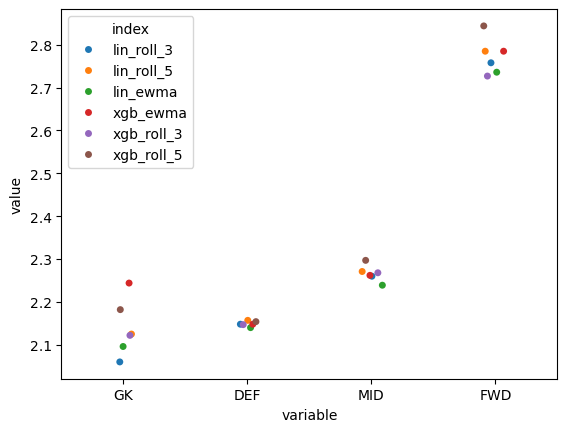

In [ ]:
df_plot = df2.reset_index().melt(id_vars='index')
sns.stripplot(data=df_plot, y='value', x='variable', hue='index')

ewma =        {'GK': 2.096, 'DEF': 2.140, 'MID': 2.239, 'FWD': 2.736}

roll_3 =      {'GK': 2.060, 'DEF': 2.148, 'MID': 2.260, 'FWD': 2.758}
roll_5 =      {'GK': 2.125, 'DEF': 2.157, 'MID': 2.271, 'FWD': 2.785}
roll_7 =      {'GK': 2.176, 'DEF': 2.168, 'MID': 2.268, 'FWD': 2.771}
roll_38 =     {'GK': 2.207, 'DEF': 2.207, 'MID': 2.283, 'FWD': 2.777}

xgb_ewma =    {'GK': 2.244, 'DEF': 2.148, 'MID': 2.262, 'FWD': 2.785}

xgb_roll_3 =  {'GK': 2.016, 'DEF': 2.172, 'MID': 2.172, 'FWD': 2.65}
xgb_roll_5 =  {'GK': 2.182, 'DEF': 2.154, 'MID': 2.297, 'FWD': 2.844}
xgb_roll_7 =  {'GK': 2.247, 'DEF': 2.170, 'MID': 2.281, 'FWD': 2.914}
xgb_roll_38 = {'GK': 2.267, 'DEF': 2.192, 'MID': 2.292, 'FWD': 2.825}

In [ ]:
ewma =        {'GK': 2.096, 'DEF': 2.140, 'MID': 2.239, 'FWD': 2.736}

roll_3 =      {'GK': 2.060, 'DEF': 2.148, 'MID': 2.260, 'FWD': 2.758}
roll_5 =      {'GK': 2.125, 'DEF': 2.157, 'MID': 2.271, 'FWD': 2.785}
roll_7 =      {'GK': 2.176, 'DEF': 2.168, 'MID': 2.268, 'FWD': 2.771}
roll_38 =     {'GK': 2.207, 'DEF': 2.207, 'MID': 2.283, 'FWD': 2.777}

xgb_ewma =    {'GK': 2.244, 'DEF': 2.148, 'MID': 2.262, 'FWD': 2.785}

xgb_roll_3 =  {'GK': 2.016, 'DEF': 2.172, 'MID': 2.172, 'FWD': 2.65}
xgb_roll_5 =  {'GK': 2.182, 'DEF': 2.154, 'MID': 2.297, 'FWD': 2.844}
xgb_roll_7 =  {'GK': 2.247, 'DEF': 2.170, 'MID': 2.281, 'FWD': 2.914}
xgb_roll_38 = {'GK': 2.267, 'DEF': 2.192, 'MID': 2.292, 'FWD': 2.825}

In [ ]:
# Create a DataFrame from the given dictionaries
dicts = {
    'ewma':        {'GK': 2.096, 'DEF': 2.140, 'MID': 2.239, 'FWD': 2.736},
    'roll_3':      {'GK': 2.060, 'DEF': 2.148, 'MID': 2.260, 'FWD': 2.758},
    'roll_5':      {'GK': 2.125, 'DEF': 2.157, 'MID': 2.271, 'FWD': 2.785},
    'roll_7':      {'GK': 2.176, 'DEF': 2.168, 'MID': 2.268, 'FWD': 2.771},
    'roll_38':     {'GK': 2.207, 'DEF': 2.207, 'MID': 2.283, 'FWD': 2.777},
    'xgb_ewma':    {'GK': 2.244, 'DEF': 2.148, 'MID': 2.262, 'FWD': 2.785},
    'xgb_roll_3':  {'GK': 2.016, 'DEF': 2.172, 'MID': 2.172, 'FWD': 2.65},
    'xgb_roll_5':  {'GK': 2.182, 'DEF': 2.154, 'MID': 2.297, 'FWD': 2.844},
    'xgb_roll_7':  {'GK': 2.247, 'DEF': 2.170, 'MID': 2.281, 'FWD': 2.914},
    'xgb_roll_38': {'GK': 2.267, 'DEF': 2.192, 'MID': 2.292, 'FWD': 2.825}
}

df = pd.DataFrame.from_dict(dicts, orient='index')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_plot = df.reset_index().melt(id_vars='index')

In [ ]:
df_plot.query('index in ["ewma", "xgb_roll_3", "xgb_roll_5"]')

,index,variable,value
0,ewma,GK,2.096
6,xgb_roll_3,GK,2.016
7,xgb_roll_5,GK,2.182
10,ewma,DEF,2.140
16,xgb_roll_3,DEF,2.172
17,xgb_roll_5,DEF,2.154
20,ewma,MID,2.239
26,xgb_roll_3,MID,2.172
27,xgb_roll_5,MID,2.297
30,ewma,FWD,2.736


<Axes: xlabel='variable', ylabel='value'>

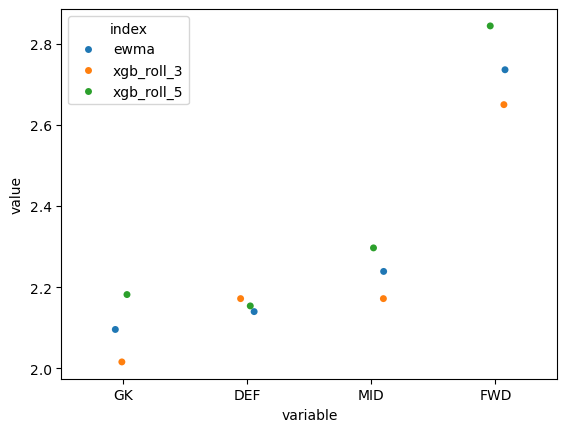

In [ ]:
sns.stripplot(data=df_plot.query('index in ["ewma", "xgb_roll_3", "xgb_roll_5"]'), y='value', x='variable', hue='index')